# Constructing InfoGan in TensorFlow

We will better understand InfoGAN by implementing them in TensorFlow step by step. We will use the MNIST dataset and learn how InfoGAN infers the code automatically based on the generator output. We build Info-DCGAN i.e we use convolutional network in the generator and discriminator instead of a vanilla neural network. 

## Import libraries

First, we will import all the necessary libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.pyplot as plt
%matplotlib inline

### Read the Dataset

Load the MNIST dataset:

In [2]:
data = input_data.read_data_sets("data/mnist",one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


Define the leaky ReLU activation function:

In [3]:
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

## Defining Generator 

Generator $G$ takes the noise $z$ and also a variable $c$ as an input and returns an image. Instead of using a fully connected layer in the generator we use a deconvolutional network just like we studied in DCGAN:

In [4]:
def generator(c, z,reuse=None):

  with tf.variable_scope('generator',reuse=reuse):
    
    #first, concatenate the noise z and the variable c
    input_combined = tf.concat([c, z], axis=1)

    #define the first layer which is a fully connected layer with batch normalization and ReLU activations
    fuly_connected1 = tf.layers.dense(input_combined, 1024)
    batch_norm1 = tf.layers.batch_normalization(fuly_connected1, training=is_train)
    relu1 = tf.nn.relu(batch_norm1)

    #define the second layer which is also fully connected with batch normalization and ReLU activations
    fully_connected2 = tf.layers.dense(relu1, 7 * 7 * 128)
    batch_norm2 = tf.layers.batch_normalization(fully_connected2, training=is_train)
    relu2 = tf.nn.relu(batch_norm2)
    
    #flatten the result of the second layer
    relu_flat = tf.reshape(relu2, [batch_size, 7, 7, 128])

    #third layer consists of deconvolution
    #that means transpose convolution operation followed by batch normalization and ReLU activations  
    deconv1 = tf.layers.conv2d_transpose(relu_flat, 
                                          filters=64,
                                          kernel_size=4,
                                          strides=2,
                                          padding='same',
                                          activation=None)
    batch_norm3 = tf.layers.batch_normalization(deconv1, training=is_train)
    relu3 = tf.nn.relu(batch_norm3)

    #fourth layer is another transpose convolution operation
    deconv2 = tf.layers.conv2d_transpose(relu3, 
                                          filters=1,
                                          kernel_size=4,
                                          strides=2,
                                          padding='same',
                                          activation=None)
    
    #apply softmax function to the result of the fourth layer and get the output
    output = tf.nn.sigmoid(deconv2) 
    return output

## Defining Discriminator


We learned that both the discriminator $D$  and  $Q$ network take the generator image and returns the output so they both share some layers. Since, they both share some layers, we attach $Q$ network to the discriminator as we learned in the architecture of InfoGAN. Instead of using fully connected layers in the discriminator, we use a convolutional network as we learned in the discriminator of DCGAN: 

In [5]:
def discriminator(x,reuse=None):

  with tf.variable_scope('discriminator',reuse=reuse):

    #define the first layer which is the convolution operation followed by leaky ReLU activation:
    conv1 = tf.layers.conv2d(x, 
                             filters=64, 
                             kernel_size=4,
                             strides=2,
                             padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=None)
    lrelu1 = lrelu(conv1, 0.2)
    
    #we also perform convolution operation in the second layer 
    #which is followed by batch normalization and leaky ReLU activation
    conv2 = tf.layers.conv2d(lrelu1, 
                             filters=128,
                             kernel_size=4,
                             strides=2,
                             padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=None)
    batch_norm2 = tf.layers.batch_normalization(conv2, training=is_train)
    lrelu2 = lrelu(batch_norm2, 0.2)
    
    #flatten the result of second layer result
    lrelu2_flat = tf.reshape(lrelu2, [batch_size, -1])

    #feed the flattened result to a fully connected layer which is the third layer and 
    #it is followed by batch normalization and leaky ReLU activation:
    
    full_connected = tf.layers.dense(lrelu2_flat, 
                          units=1024, 
                          activation=None)
    batch_norm_3 = tf.layers.batch_normalization(full_connected, training=is_train)
    lrelu3 = lrelu(batch_norm_3, 0.2)


    #compute the discriminator output
    d_logits = tf.layers.dense(lrelu3, units=1, activation=None)


    #as we learned that we attach the Q network to the discriminator. 
    #define the first layer of the Q network which takes the final layer of discriminator as inputs
    full_connected_2 = tf.layers.dense(lrelu3, 
                                     units=128, 
                                     activation=None)

    batch_norm_4 = tf.layers.batch_normalization(full_connected_2, training=is_train)
    lrelu4 = lrelu(batch_norm_4, 0.2)


    #define the second layer of Q network:
    q_net_latent = tf.layers.dense(lrelu4, 
                                    units=74, 
                                    activation=None)

    
    #estimate c:
    q_latents_categoricals_raw = q_net_latent[:,0:10]
    c_estimates = tf.nn.softmax(q_latents_categoricals_raw, dim=1)

    #return the discriminator logits and estimated c value as output:
    return d_logits, c_estimates

## Define the input placeholders


Now, we define the placeholder for the input $x$ and the noise $z$ and the variable $c$:

In [6]:
batch_size = 64
input_shape = [batch_size, 28,28,1]


x = tf.placeholder(tf.float32, input_shape)
z = tf.placeholder(tf.float32, [batch_size, 64])
c = tf.placeholder(tf.float32, [batch_size, 10])

is_train = tf.placeholder(tf.bool)

## Start the GAN!

First we feed the noise $z$ and also the variable $c$ to the generator and it will output the fake image. i.e $ fake \; x = G(z,c) $

In [7]:
fake_x = generator(c, z)

Now, we feed the real image to the discriminator $D(x)$ and get the probabillty of being real:

In [8]:
D_logits_real, c_posterior_real = discriminator(x)

Similarly, we feed the fake image to the discirminator $D(z)$ and get the probabillty of it being real and also the posterior probabilty of c:

In [9]:
D_logits_fake, c_posterior_fake = discriminator(fake_x,reuse=True)

## Computing Loss Function

Now, we will see, how to compute the loss function.



### Discriminator Loss

Discriminator loss is given as:

${L ^{D} =  - \mathbb{E}_{x \sim p_{r}(x)}[\log D(x)] - \mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z))]} $


<br>


First we will implement the first term i.e $\mathbb{E}_{x \sim p_{r}(x)}[\log D(x)]$

In [10]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real, 
                                                        labels=tf.ones(dtype=tf.float32, shape=[batch_size, 1])))

Now the second term, $\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z))]$

In [11]:
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake, 
                                                    labels=tf.zeros(dtype=tf.float32, shape=[batch_size, 1])))


The final loss can be written as:

In [12]:
D_loss = D_loss_real + D_loss_fake

### Generator Loss

Generator loss is given as:

${L^{G}= - \mathbb{E}_{z \sim p_{z}(z)}[\log (D(G(z)))] } $

In [13]:
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake, 
                                                    labels=tf.ones(dtype=tf.float32, shape=[batch_size, 1])))

### Mutual Information

We subtract mutual information from both discriminator and generator loss. So the final loss function of discriminator and generator is given as:


${L}^{D}=  {L}^{D} - \lambda I(c ,{G}(z, c)) $


${L}^{G}=  {L}^{G} - \lambda I(c ,{G}(z, c)) $

Mutual Information can be calculated as:

$I(c, G(z, c)) = \mathbb{E}_{c \sim P(c), x \sim G(z, c)} \; H(c) +  \log Q(c \vert X) $


First we define a prior for c:

In [14]:
c_prior = 0.10 * tf.ones(dtype=tf.float32, shape=[batch_size, 10])

Entropy of $c$ i.e $ H(c)$ We know that entropy is calculated as : $H(c) = - \sum_i p(c) \operatorname{log} p(c) $

In [ ]:
entropy_of_c = tf.reduce_mean(-tf.reduce_sum(c * tf.log(tf.clip_by_value(c_prior, 1e-12, 1.0)),axis=-1))

Conditional Entropy of $c$ given $x$ i.e $\log Q(c \vert X)$ 

In [15]:
log_q_c_given_x = tf.reduce_mean(tf.reduce_sum(c * tf.log(tf.clip_by_value(c_posterior_fake, 1e-12, 1.0)), axis=-1))

Mutual information is given as:

In [17]:
mutual_information = entropy_of_c + log_q_c_given_x 

Final loss of discriminator and generator:

In [18]:
D_loss = D_loss - mutual_information
G_loss = G_loss - mutual_information

## Optimizing the Loss


Now we need to optimize our generator and discriminator. So, we collect the parameters of the discriminator and generator as $\theta_D$ and $\theta_G$ respectively. 

In [19]:
training_vars = tf.trainable_variables()

theta_D = [var for var in training_vars if 'discriminator' in var.name]
theta_G = [var for var in training_vars if 'generator' in var.name]

Optimize the loss using adam optimizer:

In [20]:
D_optimizer = tf.train.AdamOptimizer(0.001).minimize(D_loss,var_list = theta_D)
G_optimizer = tf.train.AdamOptimizer(0.001).minimize(G_loss, var_list = theta_G)

## Begin Training 

 Define the number of epochs, start the TensorFlow session and initialize all variables:

In [21]:
num_epochs = 100

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

Define a helper function for visualizing results:

In [22]:
def plot(c, x):
    
    c_ = np.argmax(c, 1)

    sort_indices = np.argsort(c_, 0)
    
    x_reshape = np.reshape(x[sort_indices], [batch_size, 28, 28])
    
    x_reshape = np.reshape( np.expand_dims(x_reshape, axis=0), [4, (batch_size // 4), 28, 28])

    values = []
    
    for i in range(0,4):
        row = np.concatenate( [x_reshape[i,j,:,:] for j in range(0,(batch_size // 4))], axis=1)
        values.append(row)
        
    return np.concatenate(values, axis=0)

### Generate Handwritten Digits

Epoch: 0, iteration: 0, Discriminator Loss:3.22969841957, Generator Loss: 1.31015634537


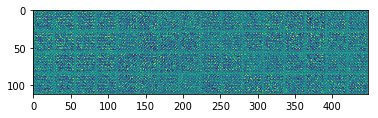

Epoch: 0, iteration: 100, Discriminator Loss:-1.36798501015, Generator Loss: -1.24912619591


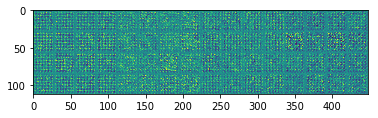

Epoch: 0, iteration: 200, Discriminator Loss:-1.43627417088, Generator Loss: -1.2681350708


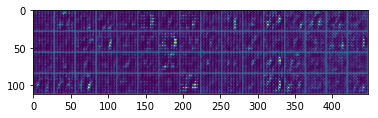

Epoch: 0, iteration: 300, Discriminator Loss:-1.40709066391, Generator Loss: -0.894130706787


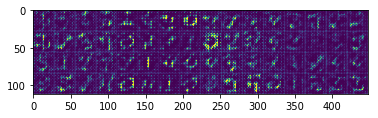

Epoch: 0, iteration: 400, Discriminator Loss:-1.39222788811, Generator Loss: -0.991786003113


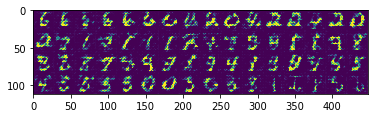

In [ ]:
#one hot encoder
onehot = np.eye(10)

#for every epochs
for epoch in range(num_epochs):
    
    #for each batch
    for i in range(0, data.train.num_examples // batch_size):
        
        #sample a batch of data
        x_batch, _ = data.train.next_batch(batch_size)
        
        #reshape the sampled data
        x_batch = np.reshape(x_batch, (batch_size, 28, 28, 1))
        
        #randomly select c
        c_ = np.random.randint(low=0, high=10, size=(batch_size,))
        
        #one hot encode c
        c_one_hot = onehot[c_]
        
        #randomly sample noise z
        z_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size,64))
        
        #feed the input x as x_batch, c as c_one_hot and noise z as z_batch
        feed_dict={x: x_batch, c: c_one_hot, z: z_batch, is_train: True}

        #train the discriminator and generator
        _ = session.run(D_optimizer, feed_dict=feed_dict)
        _ = session.run(G_optimizer, feed_dict=feed_dict)
        
        #on every 100th epoch, feed the noise to the generator and generate a fake image
        if i % 100 == 0:
            
            #discriminator and generator loss
            discriminator_loss = D_loss.eval(feed_dict)
            generator_loss = G_loss.eval(feed_dict)
            
            #generate fake image
            _fake_x = fake_x.eval(feed_dict)
            
            print("Epoch: {}, iteration: {}, Discriminator Loss:{}, Generator Loss: {}".format(epoch,i,discriminator_loss,generator_loss))
            
            #plot the generated fake image
            plt.imshow(plot(c_one_hot, _fake_x))
            plt.show()      

As you can see in the above plot, how InfoGAN learns to generate the images of handwritten digit. In the next section we will learn about one of the interesting types of GANs called CycleGAN. 